# 02 - Modelo Siamese MFCC para emparejamiento de clip con audio.
*Monserrat Montero T.*

In [1]:
from pathlib import Path
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Configuración general ---
sr_target = 48000
n_mfcc = 20
hop_length = 512
ventana = 93  # frames por ~1 segundo
salto = 46    # 50% superposición

# Dataset de etiquetas
ruta_excel = Path("etiquetado.xlsx")
df = pd.read_excel(ruta_excel)

def convertir_a_segundos(valor):
    if isinstance(valor, str) and ":" in valor:
        minutos, segundos = map(int, valor.split(":"))
        return minutos * 60 + segundos
    if isinstance(valor, (int, float)) and valor >= 0:
        return int(valor)
    return -1

df["segundo_label"] = df["segundo_inicio"].apply(convertir_a_segundos)
df_validos = df[df["segundo_label"] >= 0].reset_index(drop=True)

# --- Aquí guardaremos nuestros pares ---
X1 = []  # clip
X2 = []  # segmento estudio
y_pairs = []

# --- Función para obtener MFCC promediado por ventana ---
def get_mfcc_vector(audio, sr, start_frame):
    segmento = audio[:, start_frame:start_frame + ventana]
    if segmento.shape[1] < ventana:
        return None
    return segmento.mean(axis=1)


print("🔍 Carpetas únicas detectadas:")
print(df_validos["carpeta"].unique())
# --- Recorrer cada fila válida ---
for idx, fila in tqdm(df_validos.iterrows(), total=len(df_validos)):
    base_audio = Path(fila["audio_base"]).stem
    carpeta = fila["carpeta"].strip().strip("/").strip("\\")
    clip_nombre = fila["archivo_clip"].replace(".mp4", ".wav")
    segundo_real = fila["segundo_label"]

    # Rutas
    ruta_clip = Path("clips_syntrack") / base_audio / carpeta / "wavs" / clip_nombre
    ruta_estudio = Path("clips_syntrack") / base_audio / "cancion_estudio" / f"{base_audio}.wav"

    if not ruta_clip.exists() or not ruta_estudio.exists():
        #a esto le falta el nombre de la canción
        
        print(f"❌ Falla con:\n  - carpeta: '{carpeta}'\n - cancion: '{base_audio}'")
        print(f"- ruta_clip: {ruta_clip.exists()}\n  - ruta_estudio: {ruta_estudio.exists()}")
        continue

    # --- MFCC del clip ---
    clip_audio, _ = librosa.load(ruta_clip, sr=sr_target)
    mfcc_clip = librosa.feature.mfcc(y=clip_audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    mfcc_clip = librosa.util.normalize(mfcc_clip)
    clip_vector = get_mfcc_vector(mfcc_clip, sr_target, 0)
    if clip_vector is None:
        continue

    # --- MFCC de la canción de estudio ---
    estudio_audio, _ = librosa.load(ruta_estudio, sr=sr_target)
    mfcc_estudio = librosa.feature.mfcc(y=estudio_audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    mfcc_estudio = librosa.util.normalize(mfcc_estudio)

    # Positivo → segmento del segundo correcto
    start_frame = int((segundo_real * sr_target) / hop_length)
    positivo_vector = get_mfcc_vector(mfcc_estudio, sr_target, start_frame)
    if positivo_vector is None:
        continue

    X1.append(clip_vector)
    X2.append(positivo_vector)
    y_pairs.append(1)

    # Negativo → escoger otro segundo al azar (distinto al correcto)
    segundos_totales = mfcc_estudio.shape[1] * hop_length // sr_target
    for _ in range(2):  # generar 2 ejemplos negativos por cada positivo
        segundo_negativo = np.random.choice([s for s in range(5, segundos_totales - 5) if abs(s - segundo_real) > 3])
        start_neg = int((segundo_negativo * sr_target) / hop_length)
        negativo_vector = get_mfcc_vector(mfcc_estudio, sr_target, start_neg)
        if negativo_vector is None:
            continue

        X1.append(clip_vector)
        X2.append(negativo_vector)
        y_pairs.append(0)

# Convertir a numpy
X1 = np.array(X1)
X2 = np.array(X2)
y_pairs = np.array(y_pairs)

print(f"✅ Dataset de pares generado: {X1.shape}, {X2.shape}, etiquetas: {y_pairs.shape}")

🔍 Carpetas únicas detectadas:
['clips_david' 'clips_youtube' 'clips_monse' 'clips_tiktok' 'clips_camera'
 'clips_city_session' 'clips_chuncho' 'clips_nico']


100%|██████████| 196/196 [02:00<00:00,  1.62it/s]

✅ Dataset de pares generado: (588, 20), (588, 20), etiquetas: (588,)


In [2]:
from tensorflow.keras import layers, models, Input, Model
import tensorflow as tf

# Tamaño del input (n_mfcc = 20)
input_dim = X1.shape[1]

# --- Encoder compartido ---
def build_encoder():
    inp = Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dense(32, activation='relu')(x)
    return Model(inp, x, name="Encoder")

encoder = build_encoder()

# --- Inputs siameses ---
input_1 = Input(shape=(input_dim,))
input_2 = Input(shape=(input_dim,))

# --- Aplicar encoder a ambos ---
encoded_1 = encoder(input_1)
encoded_2 = encoder(input_2)

# --- Comparación (distancia absoluta entre embeddings) ---
diff = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([encoded_1, encoded_2])

# --- Clasificación final ---
x = layers.Dense(32, activation='relu')(diff)
x = layers.Dense(1, activation='sigmoid')(x)

siamese_model = Model(inputs=[input_1, input_2], outputs=x)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 32)        │      3,424 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32)        │          0 │ Encoder[0][0],    │
│                     │                   │            │ Encoder[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = siamese_model.fit(
    [X1, X2], y_pairs,
    batch_size=32,
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6074 - loss: 0.6858 - val_accuracy: 0.6695 - val_loss: 0.6691
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6383 - loss: 0.6616 - val_accuracy: 0.6695 - val_loss: 0.6506
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6914 - loss: 0.6206 - val_accuracy: 0.6695 - val_loss: 0.6358
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6371 - loss: 0.6413 - val_accuracy: 0.6695 - val_loss: 0.6287
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6601 - loss: 0.6169 - val_accuracy: 0.6695 - val_loss: 0.6236
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6557 - loss: 0.6160 - val_accuracy: 0.6695 - val_loss: 0.6210
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6746 - loss: 0.6128 - val_accuracy: 0.6695 - val_loss: 0.6204
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6496 - loss: 0.6132 - val_accuracy: 0.6695 - val_loss

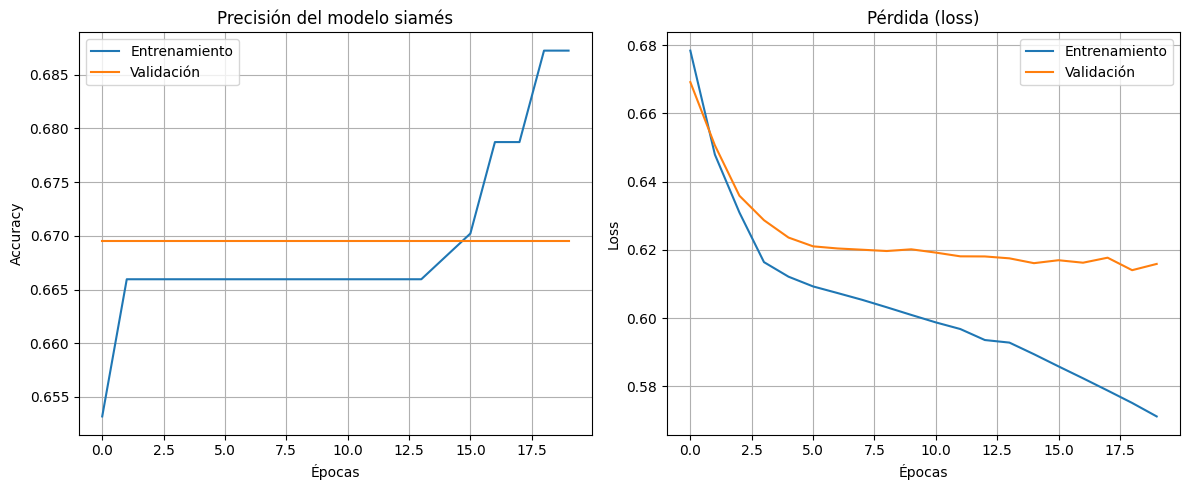

In [4]:
import matplotlib.pyplot as plt

# --- Precisión ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo siamés")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# --- Pérdida ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida (loss)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
from pathlib import Path
import librosa
import numpy as np

# ---------------------
# 🔧 Parámetros del clip
# ---------------------
nombre_cancion = "clocks_coldplay"   # 🔁 cámbialo por la canción que quieras
nombre_clip    = "clip05.wav"        # 🔁 cámbialo por el clip a probar
carpeta        = "clips_youtube"     # 🔁 subcarpeta donde está el clip

# Rutas
ruta_clip    = Path("clips_syntrack") / nombre_cancion / carpeta / "wavs" / nombre_clip
ruta_estudio = Path("clips_syntrack") / nombre_cancion / "cancion_estudio" / f"{nombre_cancion}.wav"

# Cargar y procesar clip
clip_audio, _ = librosa.load(ruta_clip, sr=sr_target)
mfcc_clip = librosa.feature.mfcc(y=clip_audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
mfcc_clip = librosa.util.normalize(mfcc_clip)
clip_vector = get_mfcc_vector(mfcc_clip, sr_target, 0)
if clip_vector is None:
    raise ValueError("Clip demasiado corto para extraer vector.")

# Cargar canción de estudio y calcular MFCC
estudio_audio, _ = librosa.load(ruta_estudio, sr=sr_target)
mfcc_estudio = librosa.feature.mfcc(y=estudio_audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
mfcc_estudio = librosa.util.normalize(mfcc_estudio)

# Crear vectores de comparación por batch
vectores_estudio = []
segundos = []

for s in range(5, (mfcc_estudio.shape[1] - ventana) * hop_length // sr_target - 5):
    frame_inicio = int((s * sr_target) / hop_length)
    vector_estudio = get_mfcc_vector(mfcc_estudio, sr_target, frame_inicio)
    if vector_estudio is None:
        continue
    vectores_estudio.append(vector_estudio)
    segundos.append(s)

# Convertir a arrays
X1_batch = np.tile(clip_vector, (len(vectores_estudio), 1))
X2_batch = np.array(vectores_estudio)

# 🔥 Evaluar en batch (más rápido y sin pérdida de precisión)
predicciones = siamese_model.predict([X1_batch, X2_batch], verbose=0).flatten()

# Obtener segundo con mayor similitud
mejor_segundo = segundos[np.argmax(predicciones)]
print(f"\n🎯 El modelo predice que el clip coincide mejor con el segundo ~{mejor_segundo} de la canción original.")


🎯 El modelo predice que el clip coincide mejor con el segundo ~211 de la canción original.
